# Prédire le prix d'un panier étudiant moyen

Notre but au cours de ce projet a été de trouver, de visualiser des données afin de créer un modèle qui nous permettrait de prédire le prix du panier alimentaire d'un étudiant moyen selon différentes conjonctures économiques et de production. Notre travail s'est axé vers une démarche de prédiction mathématique simple et ne se rique pas à faire des interprétations économétriques.

**Problématique**

Comment peut-on expliquer l'évolution du prix d'un panier d'étudiant type? Est-ce qu'on peut prédire son prix?

Les notebooks importants dans notre projet sont les suivants: celui-ci qui est le principal sur lequel nous avons travaillé sur la visualisation des données ainsi que sur le modèle de régression linéaire. Le notebook data collection qui regroupe notre travail sur l'extraction de données via une API et le notebook récupération de données qui continue le travail du précédent en raffinant notre base de données pour la rendre prête à l'utilisation.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Nous importons la base de données que nous avons préparé dans le notebook 'récupération des données'

In [30]:
url='https://raw.githubusercontent.com/yousralinael/projet_python_ds/main/sous_donn%C3%A9es_finales.csv'
dff_=pd.read_csv(url,sep=",")

# Visualisation

Avant de faire des visualisations, il sied de réaliser quelques statistiques descriptives.

In [ ]:
dff_.describe()

,Panier Mensuel Moyen,IPC,IPP,Prod céréales,Prod graines(huile),Prod légumes,Prod fruits,FR_prod_bovine,FR_prod_chicken
count,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000
mean,95.961111,94.667361,97.575463,105.166675,109.650825,99.668120,110.293478,125.381759,68441.840509
std,7.297724,6.878539,5.907386,22.141417,42.618921,30.353036,19.686301,8.879517,8390.569034
min,79.920000,83.090000,85.600000,68.339471,58.618332,67.725065,80.075248,106.340000,45489.000000
25%,90.252500,87.517500,94.275000,91.794167,84.430381,77.810399,98.983364,118.962500,62492.840000
50%,98.285000,94.750000,98.950000,99.666143,96.646667,87.650977,103.850000,124.550000,67541.380000
75%,101.942500,100.197500,102.900000,119.705919,117.625232,107.220833,115.453738,131.355000,74074.677500
max,106.760000,107.150000,105.300000,163.631142,218.905330,213.486758,168.462673,149.340000,89561.400000


En se concentrant que sur le prix moyen du panier mensuel par exemple, on voit que la moyenne est de 95€ et que les valeurs passent de 83€ à 106€. Quelles sont alors les variables qui pourront expliquer cette évolution?

In [ ]:
cor=dff_.corr()
cor.shape

(9, 9)

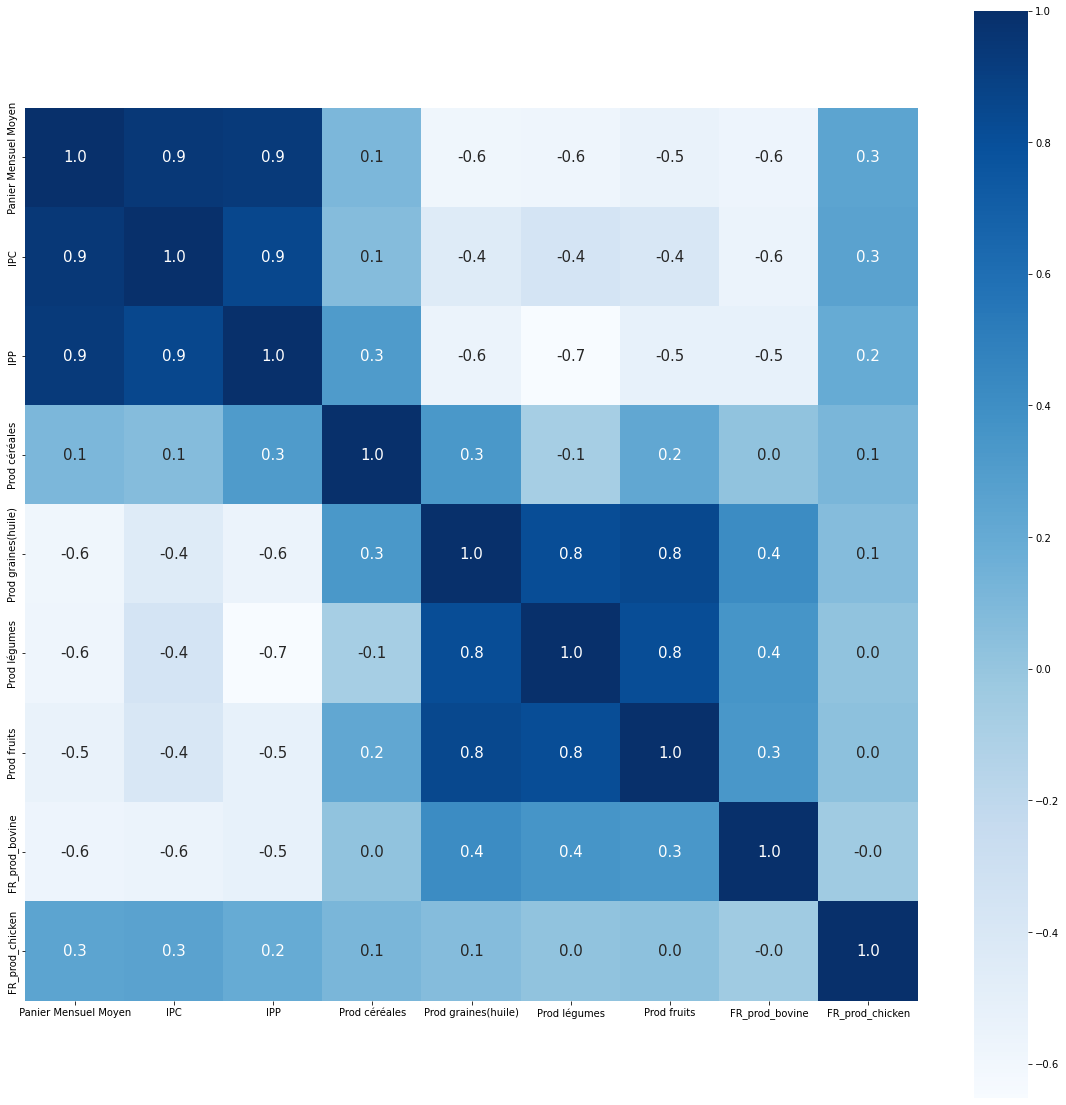

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(cor, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Blues')

D'après la représentation de la matrice, on remarque qu'il y a une forte corrélation entre le prix du panier et les indices des prix à la production et à la consommation, ce qui semble a priori logique. Par contre, on remarque qu'il y a une corrélation négative  entre prix du panier et la production bovine ce qui n'est pas justifiable. Ainsi, il ne suffit pas de s'appuyer sur la corrélation pour analyser les rapports entre les variables.



On s'interesse maintenant à l'évolution de quelques variables.

In [ ]:
L=dff_.index
L1=list(L[i] for i in range(216)) #taking the list of dates

In [ ]:
#Evolution du prix du panier mensuel
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=L1, y=list(dff_[' Panier Mensuel Moyen '])))

fig.update_layout(
    title_text="Evolution du prix du panier mensuel"
)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=L1, y=list(dff_['IPC']),name='IPC'))
fig.add_trace(
    go.Scatter(x=L1, y=list(dff_['IPP']),name='IPP'))

fig.update_layout(
    title_text="Evolution des indices"
)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

On remarque que l'allure de la courbe du prix du panier ressemble à celle des indices.


---

Ces remarques sont à confirmer (ou rejetter) par le modèle qu'on a choisi.

# Le modèle et régressions linéaires
Comme on observe une possible relation linéaire entre le prix du panier et les deux indices, nous allons effectuer plusieurs régressions linéaires pour vérifier cela.



Le modèle sera de la forme suivante:



Prix = alpha + Beta1*Variable1 + Beta2*Variable2 +...+ epsilon 


où le modèle s'entraîne à déterminer par le calcul les différents Beta et l'epsilon. Ces coefficients représentent chacun le degré de corrélation entre le prix et la variable auquel il est associé.

In [ ]:
from sklearn import linear_model #on utilisera le package sklearn pour ce faire.

In [ ]:
dff_.head()

,Période,Panier Mensuel Moyen,IPC,IPP,Prod céréales,Prod graines(huile),Prod légumes,Prod fruits,FR_prod_bovine,FR_prod_chicken
0,2002-01,82.93,83.85,85.7,103.651502,207.367128,213.486758,162.572370,149.34,62043.0
1,2002-02,81.88,83.64,85.6,100.530575,202.933468,191.311962,155.543274,127.47,69687.0
2,2002-03,82.76,83.68,86.0,97.409648,198.499807,169.137166,148.514179,135.59,82800.0
3,2002-04,82.88,83.76,86.4,94.288720,194.066146,146.962371,141.485084,136.37,64757.0
4,2002-05,83.11,83.99,86.3,96.601878,195.615256,146.817438,130.607657,139.47,66671.0


Dans la suite on entraîne 4 modèles, deux modèles de régressions linéaires simples avec comme seule variable explicative les indices IPC et IPP puis un modèle utilisant ces deux-là en même temps. Ces 3 modèles sont les plus importants car ce sont les deux variables qui sont en théorie les plus signifiantes statistiquement. On entraîne ensuite unn quatrième modèle qui cette fois-ci utilise toutes les variables d'indices et de production qui composent notre base.

In [ ]:
reg_IPC = linear_model.LinearRegression() #on crée notre objet de régression linéaire
reg_IPC.fit(dff_[['IPC']], dff_[' Panier Mensuel Moyen ']) #on entraîne grâce à la méthode fit notre modèle

LinearRegression()

In [ ]:
reg_IPC.coef_ #on obtient le coefficient

array([1.00315395])

In [ ]:
reg_IPC.intercept_ #on obtient l'erreur

0.9951734086133683

In [ ]:
reg_IPP = linear_model.LinearRegression() 
reg_IPP.fit(dff_[['IPP']], dff_[' Panier Mensuel Moyen '])

LinearRegression()

In [ ]:
reg_IPP.coef_

array([1.14832704])

In [ ]:
reg_IPP.intercept_

-16.087431367016066

In [ ]:
reg_indices = linear_model.LinearRegression() 
reg_indices.fit(dff_[['IPP','IPC']], dff_[' Panier Mensuel Moyen '])

LinearRegression()

In [ ]:
reg_indices.coef_

array([0.55385643, 0.59504504])

In [ ]:
reg_indices.intercept_

-14.41302986056931

On remarque donc que les indices sont assez fortement corrélés au prix du panier étudiant et ce de manière équivalente pour chacun d'eux.
Effectuons d'autres régressions, cette fois-ci regroupant toutes les variables explicatives du modèle, à savoir: les indices de prix à la consommation et de prix à la production et les quantités produites des différentes matières premières.

In [ ]:
reg_complete = linear_model.LinearRegression()
reg_complete.fit(dff_[['IPP','IPC','Prod céréales','Prod graines(huile)','Prod légumes','Prod fruits','FR_prod_bovine','FR_prod_chicken']], dff_[' Panier Mensuel Moyen '])

LinearRegression()

In [ ]:
reg_complete.coef_

array([ 3.33184777e-01,  6.79576760e-01, -1.03486241e-02, -5.97490953e-03,
       -3.77079075e-02,  8.23423342e-03, -4.23339754e-03,  3.27188115e-05])

In [ ]:
reg_complete.intercept_

2.001746944988426

Nous allons désormais utiliser les différents des trois premiers modèles pour prédire le prix d'un panier étudiant et voir si notre modèle est suffisamment entraîné.
En prenant les données de janvier 2020, on a un panier étudiant à 102,98€ (pour calculer on a utilisé les prix des différents produits la dernière fois qu'ils étaient disponibles).


IPP=107,32

IPC=102,7.

Comme les données sur les prix des différents produits, il nous est difficile de trouver des données réelles sur la production qui sont toutes renseignées sur un même mois. On observerait néanmoins le même type de résultats que pour les prédictions avec les modèles indices avec cette fois-ci encore plus de précision.


In [ ]:
reg_IPC.predict([[102.7]]) #cette méthode nous permet donc de prédire le prix de notre panier

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



array([104.01908458])

In [ ]:
reg_IPP.predict([[107.32]])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



array([107.15102647])

In [31]:
reg_indices.predict([[107.32,102.7]])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([106.13796751])

On voit donc que le modèle avec les indices est assez proche de la réalité. Si les valeurs obtenues sont supérieures à celle du panier étudiant réel c'est parce que ce panier étudiant ne date pas réellement de janvier 2020 comme certaines de ses composantes ont eu leur prix extraits de périodes antérieures et que ces prix-là ont logiquement augmenté dans la même mesure que nos indices. Ainsi, si nous avions testé notre modèle avec des données exactes nous aurions obtenu des résultats quasi égaux à ceux observés en théorie.

Quant aux conclusions que l'on peut tirer de notre modèle, on voit que la relation linéaire que l'on avait prévisualisé s'est vérifiée pour ce qui est des indices. Il faut désormais garder à l'esprit que ce modèle suppose une hypothèse très forte qui est l'indépendance des différentes variables explicatives qui peut ne pas être la réalité dans notre cas. On aurait pu utiliser la méthode des random forest pour pallier ce problème. Il n'en reste pas moins que l'entraînement de notre modèle a été plutôt fructueuse que l'inverse. 

Le modèle des random forest est une des pistes d'amélioration pour notre rendu.